## Hands-On Lab: Fine-Tuning Phi-1.5 on Legal Contracts

---

### **Before You Begin: Update Your Google Colab Runtime**

To ensure the fine-tuning process runs smoothly, you must switch your Google Colab environment to a GPU runtime.

Follow these steps:

1. Go to the **top-left corner** of your Colab window.  
2. Click on the **Runtime** menu.  
3. Select **Change runtime type**.
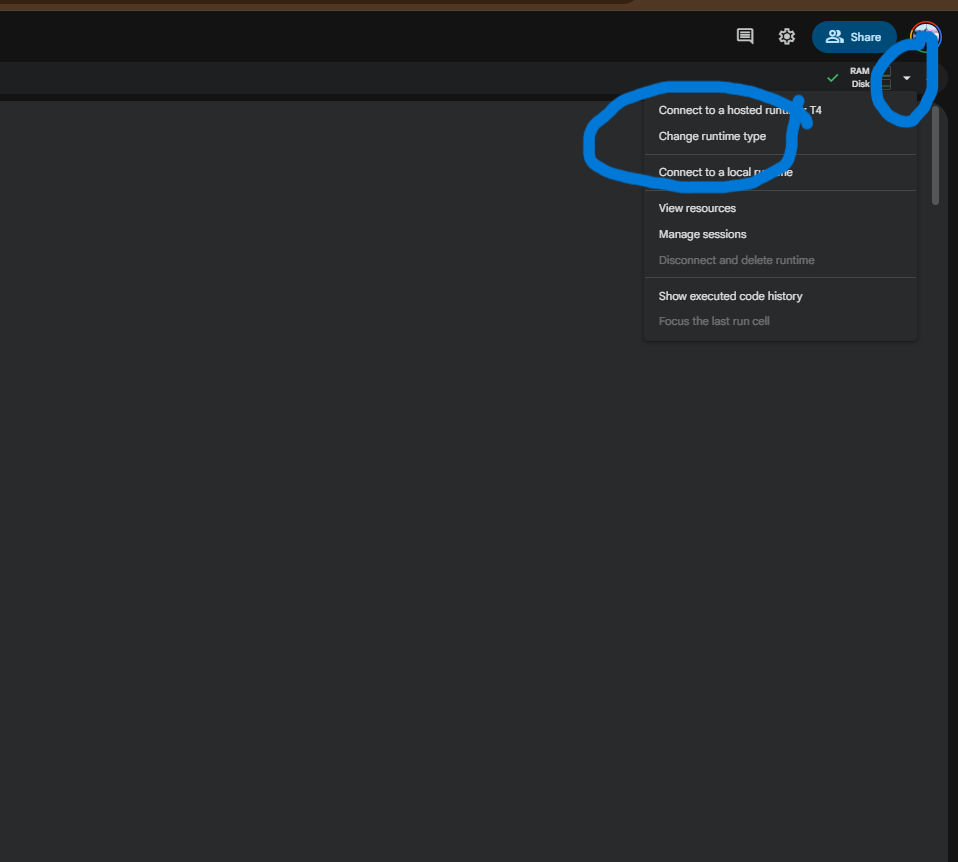
4. Under **Hardware accelerator**, choose **T4 GPU**.  
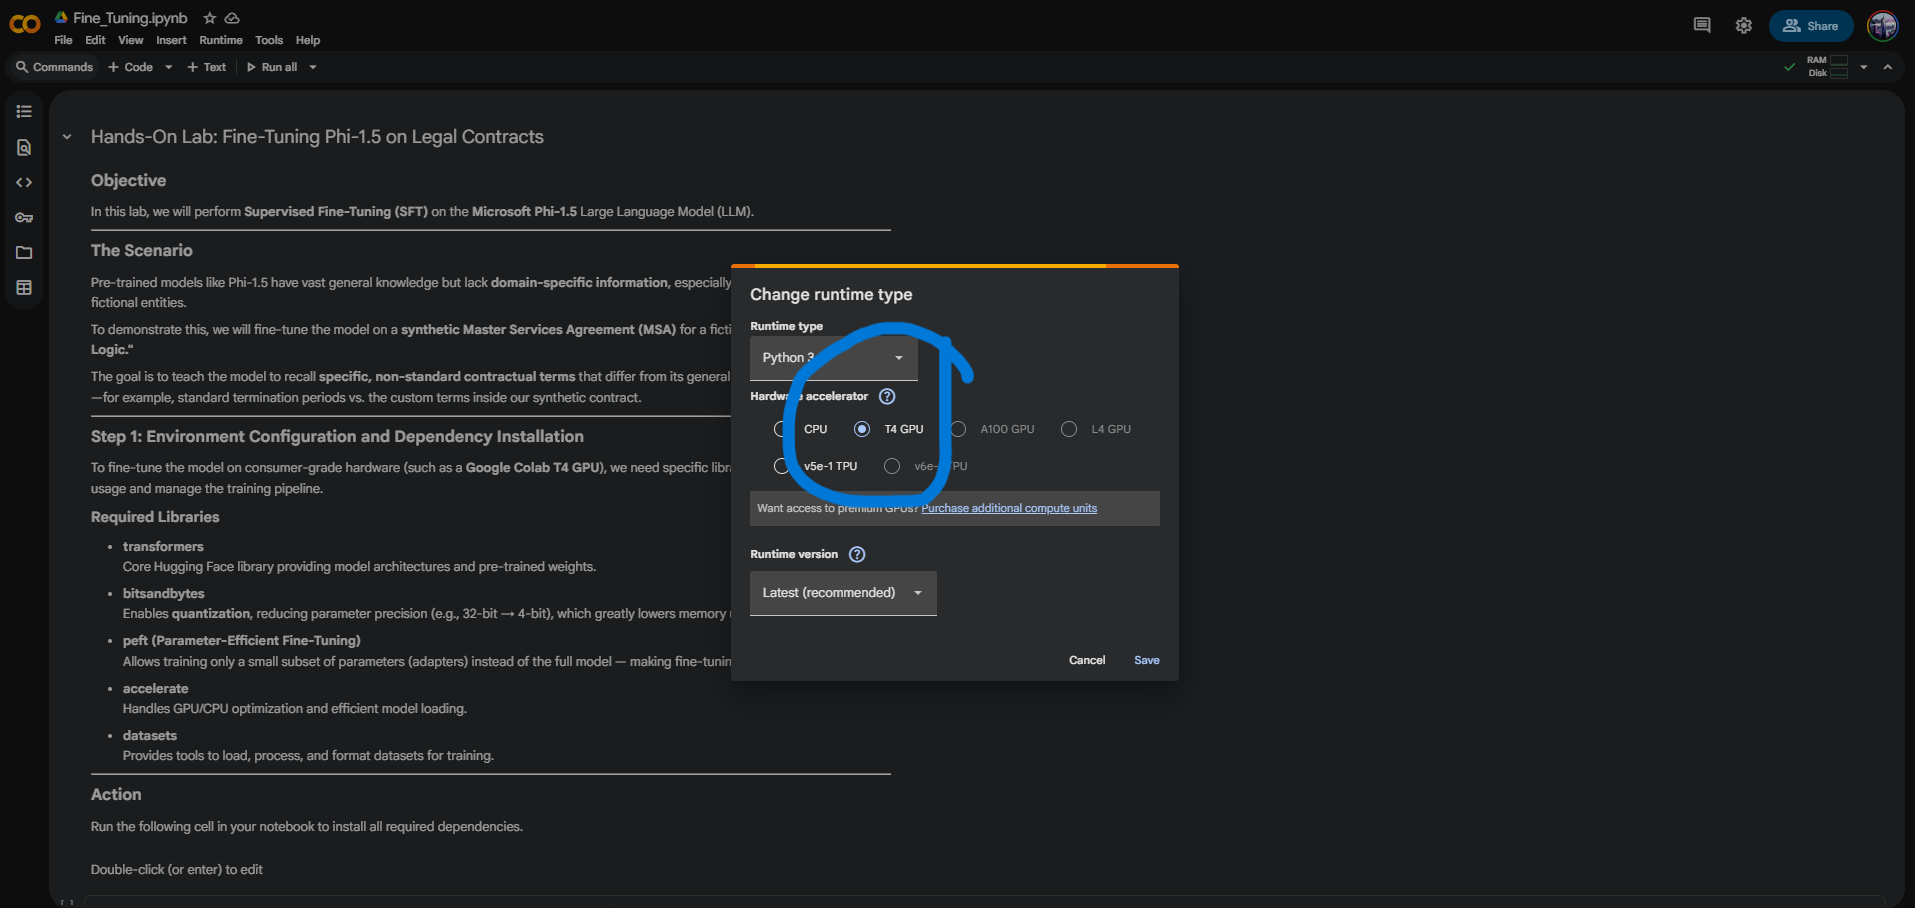
5. Click **Save**.

Your environment is now ready for GPU-accelerated fine-tuning.

---

### **Objective**
In this lab, we will perform **Supervised Fine-Tuning (SFT)** on the **Microsoft Phi-1.5** Large Language Model (LLM).

---

### **The Scenario**
Pre-trained models like Phi-1.5 have broad general knowledge but lack **domain-specific details**, especially for legal or contractual content.

To demonstrate this limitation, we will fine-tune the model on a **Kaseya Master Agreement (MSA)** PDF/TXT file.  

This will teach the model to recall **specific contractual terms** such as limitation periods, payment terms, automatic renewals, and termination clauses that are **unique to this contract**.


---

### **Step 1: Environment Configuration and Dependency Installation**

To perform fine-tuning on consumer-grade hardware (such as a **Google Colab T4 GPU**), we need several libraries that optimize memory usage and support efficient training.

#### **Required Libraries**

- **transformers**  
  Core Hugging Face library for model architectures and pre-trained weights.

- **bitsandbytes**  
  Enables **quantization** (e.g., 32-bit → 4-bit), dramatically reducing GPU memory needs.

- **peft (Parameter-Efficient Fine-Tuning)**  
  Allows training only a small set of parameters (adapters), reducing compute cost.

- **accelerate**  
  Handles optimized hardware usage and model loading.

- **datasets**  
  Provides utilities for loading, formatting, and preprocessing datasets.

---

### 👉 **Action**  
Run the following cell in your Colab notebook to install these dependencies.


In [ ]:
# Cell 1 - Install libs
!pip install -q transformers datasets peft accelerate bitsandbytes torch sentencepiece
!pip install -q PyPDF2
!pip install pyboxen


### **Cell 2 — Importing Required Libraries**

This cell loads all essential Python libraries needed for fine-tuning a language model.

#### 🔹 What this cell does
It imports:
- **Core Python utilities** (`os`, `io`, `json`, `random`)  
  Used for file handling, text processing, and general utilities.
- **PyTorch**  
  Required for all deep-learning operations and GPU usage.
- **Hugging Face Transformers**  
  Used to load the tokenizer, base model, training utilities, and data collators.
- **Datasets Library**  
  Helps create and manage training datasets.
- **PEFT (Parameter-Efficient Fine-Tuning)**  
  Enables LoRA fine-tuning so we train only small adapter layers instead of the full model.
- **PyPDF2**  
  Allows extracting text from uploaded PDF contract files.
- **Google Colab File Upload**  
  Lets students upload their contract document directly into the notebook.

#### 🔹 Why this is important
- These imports form the **foundation** of the fine-tuning workflow.
- They allow us to load datasets, prepare the model, read contracts, and run training.
- The environment checks (PyTorch version + CUDA availability) help ensure that the notebook is correctly configured to use a GPU for faster training.



In [ ]:
# Cell 2 - Imports and checks
import os
import io
import json
import random
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset, load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

import PyPDF2
from google.colab import files

print("✅ Imports complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Imports complete
PyTorch version: 2.9.0+cu126
CUDA available: True


# Cell 3 - Upload Contract File

## Dowload Contract File : [Click Here](https://drive.google.com/file/d/1MRevboHRREC6aZMmMCI4r5WweT_ys-q8/view?usp=sharing)

**Purpose:**  
This cell allows users to upload the contract document that will be used for fine-tuning. It supports both PDF and TXT formats.

**Why we use it:**  
- PDF files are read using `PyPDF2` to extract text.  
- TXT files are read directly.  
- The extracted text is stored in a variable (`contract_text`) that will be used as context for generating and fine-tuning responses.


In [ ]:
# Cell 3 - Upload contract file
print("=" * 60)
print("📄 UPLOAD YOUR CONTRACT DOCUMENT (PDF or TXT)")
print("=" * 60)

uploaded = files.upload()
contract_text = ""

for filename, content in uploaded.items():
    print(f"\n✅ File uploaded: {filename}")
    if filename.lower().endswith(".pdf"):
        pdf_file = io.BytesIO(content)
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text = page.extract_text()
            if text:
                contract_text += text + "\n"
    elif filename.lower().endswith(".txt"):
        contract_text = content.decode("utf-8")
    else:
        print("❌ Unsupported format - please upload PDF or TXT")

if contract_text:
    print("\n✅ Contract loaded")
    print(f"Contract length: {len(contract_text)} characters")
    print("First 300 chars preview:")
    print(contract_text[:300].replace("\n", " "))
else:
    raise ValueError("No contract text found. Upload a PDF or TXT.")


📄 UPLOAD YOUR CONTRACT DOCUMENT (PDF or TXT)


Saving Reference MSA Document from the Basic Prompt Engineering Lab.pdf to Reference MSA Document from the Basic Prompt Engineering Lab (2).pdf

✅ File uploaded: Reference MSA Document from the Basic Prompt Engineering Lab (2).pdf

✅ Contract loaded
Contract length: 94140 characters
First 300 chars preview:
KASEYA MASTER  AGREEMENT Effective as of April 1, 2024This Master Agreement (the “Agreement”) is a binding, legal contract between the Kaseya Af liate speci ed on Exhibit A bas ed on your billing addr ess as provided by you to Kaseya during the registration process (“Kaseya,” “we” or “us”) and the e


# Cell 4 - Load Base Model & Tokenizer

**Purpose:**  
This cell loads the pre-trained base language model (`microsoft/phi-1_5`) and its tokenizer.

**About the Model:**  
- **Phi-1.5** is a large language model designed for instruction-following tasks.  
- It is capable of understanding and generating human-like text across various domains.  
- Using this model as a base allows us to **fine-tune it on domain-specific data** (like contract text) without training from scratch.  

**Why we use it:**  
- The **tokenizer** converts text into tokens that the model can process.  
- The **base model** provides general language understanding and generation capabilities.  
- Setting the `pad_token` ensures proper handling of sequences during training and generation.


In [ ]:
# Cell 4 - Load base model & tokenizer
MODEL_NAME = "microsoft/phi-1_5"  # change if you want a different base

print(f"Loading model: {MODEL_NAME} (this can take a few minutes)...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
# ensure pad token exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("✅ Base model & tokenizer loaded")


Loading model: microsoft/phi-1_5 (this can take a few minutes)...
✅ Base model & tokenizer loaded


# Cell 5 - Test Base Model Generation

**Purpose:**  
This cell tests how the base model responds to a sample question using the uploaded contract text as context.

**Tokenizer and Model Explanation:**  
- The **tokenizer** converts human-readable text into numeric tokens that the model can process.  
- The **model** takes these tokens as input and generates output tokens, which are then converted back into text by the tokenizer.  
- Using the tokenizer ensures that the input respects the model's vocabulary and maximum sequence length.  
- Special tokens like `pad_token` and `eos_token` help the model understand padding and where text ends.

**Why we use it:**  
- To evaluate the **base model's understanding** of the contract before fine-tuning.  
- The function `generate_response` constructs a prompt including the contract excerpt and question.  
- It uses **greedy decoding** (no randomness) for consistent answers.  
- This serves as a **baseline** to compare with the fine-tuned model later.


In [ ]:
# Cell 5 - Test base model generation
TEST_QUESTION = "What is the limitation period for filing claims under this agreement?"

def generate_response(model, tokenizer, question, contract_text, max_contract_chars=3000, max_new_tokens=200):
    prompt = (
        f"Based on the following contract, answer the question concisely using only the contract. No assumptions.\n\n"
        f"Contract: {contract_text[:max_contract_chars]}\n\n"
        f"Question: {question}\n\nAnswer:"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.3,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2
        )
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract answer after "Answer:" to keep it consistent
    if "Answer:" in text:
        answer = text.split("Answer:")[-1].strip()
    else:
        answer = text[len(prompt):].strip()
    return answer.split("\n\n")[0].strip()

print("\n📝 Test question to base model:")
print(TEST_QUESTION)
base_ans = generate_response(base_model, tokenizer, TEST_QUESTION, contract_text)
print("\n🤖 Base model responded:\n", base_ans)



📝 Test question to base model:
What is the limitation period for filing claims under this agreement?

🤖 Base model responded:
 The limitation period for filing claims under this agreement is two years from the date of signing the agreement.


# Cell 6 - Prepare Training Dataset (Prompt / Completion Format)

**Purpose:**  
This cell prepares the dataset for fine-tuning the model using **prompt-completion pairs**.

**Why we use it:**  
- Each training example consists of a **prompt** (the question) and a **completion** (the answer).  
- The prompt format is designed to **match exactly how we will ask questions during inference**, ensuring the fine-tuned model learns the correct mapping.  
- Replicating the data (`expanded = qa_pairs * 20`) increases the number of examples for better learning during LoRA fine-tuning.  
- Adding `eos_token` at the end of the completion tells the model **where to stop generating**, preventing extra text.  
- Using a HuggingFace `Dataset` makes it easy to feed the examples into the training pipeline.


In [ ]:
# Cell 6 - Prepare training dataset (prompt/completion format)
print("="*60)
print("📊 Preparing fine-tuning dataset (prompt / completion format)")
print("="*60)

# Your canonical Q/A pairs (adjust answers if needed)
qa_pairs = [
    {"question": "What is the limitation period for filing claims under this agreement?",
     "answer": "Claims must be filed within two (2) years after the Claim accrued, as stated in Section 14(a)."},
    {"question": "What are the payment terms for invoices?",
     "answer": "All Fees are payable in the currency specified in the Order, are due upon receipt of invoice and are non-refundable unless a billing error is confirmed."},
    {"question": "What happens if I terminate service during the Committed Service Term?",
     "answer": "If you terminate Service during a Committed Service Term for any reason other than Kaseya's breach, a lump sum payment equal to 100% of the monthly unpaid Service Subscription fee times the number of months remaining will be due immediately."},
    {"question": "What is the automatic renewal policy?",
     "answer": "Committed Service Terms will automatically renew for additional terms equal in length to the expiring term unless either party gives notice of non-renewal at least thirty (30) days prior to the end of the relevant term."},
    {"question": "What is the governing law for this agreement?",
     "answer": "The agreement is governed by the laws of the State of Delaware, USA, without reference to conflicts of law principles, as stated in Section 14(a)."},
    {"question": "Where must disputes be filed?",
     "answer": "Disputes must be adjudicated in the state and federal courts located in Miami-Dade County, Florida, with exclusive jurisdiction."},
    {"question": "What is the liability limitation?",
     "answer": "Kaseya's total liability is limited to direct damages only in an amount equal to the fees received related to the specific product or service subscription in the six (6) calendar months prior to the incident."},
    {"question": "Can I participate in class action lawsuits?",
     "answer": "No, you waive your right to participate as a plaintiff or class member in any class action, consolidated litigation, or representative proceeding. Claims must be brought on an individual basis."},
    {"question": "What is the notice period for agreement termination?",
     "answer": "Either party may terminate this Agreement without cause upon 30 calendar days written notice."},
    {"question": "What are the warranty terms for software and services?",
     "answer": "Kaseya warrants that for thirty (30) days from first use, the Software and Services will operate substantially pursuant to the Documentation."}
]

# Expand dataset (optional) - replicate to give enough steps for LoRA
expanded = qa_pairs * 20
random.shuffle(expanded)

# Format into prompt/completion pairs
examples = []
for ex in expanded:
    # VERY IMPORTANT: prompt must match inference prompt exactly (question + 'Answer:')
    prompt = (
        "You must answer ONLY using the contract. No assumptions. No extra explanations.\n\n"
        f"Question: {ex['question']}\n\nAnswer:"
    )
    completion = " " + ex['answer'] + tokenizer.eos_token  # leading space, then answer, then eos
    examples.append({"prompt": prompt, "completion": completion})

# Build a HuggingFace Dataset (in-memory)
dataset = Dataset.from_list(examples)
print(f"✅ Created dataset with {len(dataset)} examples")


📊 Preparing fine-tuning dataset (prompt / completion format)
✅ Created dataset with 200 examples


# Cell 7 - Tokenize and Prepare Labels

**Purpose:**  
This cell tokenizes the prompt-completion pairs and prepares the input tensors for training.

**Why we use it:**  
- **Tokenization** converts text into numeric IDs the model can understand.  
- The **attention mask** tells the model which tokens are real data vs padding.  
- **Labels** are set equal to `input_ids` for causal language modeling; the trainer will handle shifting internally.  
- Padding/truncation ensures all sequences are the same length (`max_length=512`) for batch training.  
- The tokenized dataset is ready to feed into the `Trainer` for fine-tuning.


In [ ]:
# Cell 7 - Tokenize and prepare labels
max_length = 512

def tokenize_and_build_labels(example):
    # Tokenize prompt+completion as a single sequence
    enc = tokenizer(example["prompt"] + example["completion"],
                    truncation=True, max_length=max_length, padding="max_length")
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    # For causal LM, labels = input_ids (trainer will shift internally)
    labels = input_ids.copy()
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

tokenized = dataset.map(tokenize_and_build_labels, remove_columns=dataset.column_names, batched=False)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("✅ Tokenized dataset shape:", len(tokenized))


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

✅ Tokenized dataset shape: 200


# Cell 8 - Prepare Model for LoRA Fine-Tuning

**Purpose:**  
This cell applies **LoRA (Low-Rank Adaptation)** to the base model, making it efficient to fine-tune on domain-specific data.

**Why we use it:**  
- **LoRA** fine-tunes only a small subset of model parameters (here, `q_proj` and `v_proj` in attention layers), reducing memory and compute requirements.  
- The base model is reloaded to keep `base_model` untouched for comparison.  
- `r` and `lora_alpha` control the low-rank adaptation.  
- Using LoRA allows training large models like Phi-1.5 on limited resources, without full model updates.  
- `trainable_params` shows how many parameters are updated during fine-tuning, usually a small fraction of the total.


In [ ]:
# Cell 8 - Prepare model for LoRA fine-tuning
# Load base model again as model_to_train to avoid modifying base_model used earlier
model_to_train = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto"
)

# If using 8-bit or 4-bit training you'd prepare differently; here we apply simple LoRA on full-fp16
# Optionally use prepare_model_for_kbit_training if using quantization - keep for future
# model_to_train = prepare_model_for_kbit_training(model_to_train)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model_to_train = get_peft_model(model_to_train, lora_config)

trainable_params = sum(p.numel() for p in model_to_train.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_to_train.parameters())
print(f"✅ LoRA applied. Trainable params: {trainable_params:,} / {total_params:,}")


✅ LoRA applied. Trainable params: 3,145,728 / 1,421,416,448


# Cell 9 - Training Configuration

**Purpose:**  
This cell sets up the **training parameters** and data collator for fine-tuning the model.

**Why we use it:**  
- `TrainingArguments` define hyperparameters like **batch size, learning rate, number of epochs**, and **gradient accumulation**.  
- `fp16` enables **mixed-precision training** for faster computation if GPU is available.  
- `save_strategy="epoch"` saves the model after each epoch.  
- `DataCollatorForLanguageModeling` batches the tokenized examples and prepares them for **causal language modeling** (no masked language modeling).  
- These configurations ensure **stable and efficient fine-tuning** of the LoRA-adapted model.


In [ ]:
# Cell 9 - Training configuration
output_dir = "./phi_contract_finetuned"

per_device_batch = 1
gradient_accumulation_steps = 8
num_train_epochs = 3

# only use fp16 if CUDA is available
fp16_flag = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_batch,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=3e-4,
    fp16=fp16_flag,
    save_strategy="epoch",
    logging_steps=10,
    remove_unused_columns=False,
    save_total_limit=2,
    report_to="none"
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
print("✅ TrainingArguments & DataCollator ready")


✅ TrainingArguments & DataCollator ready


# Cell 10 - Create Trainer and Train

**Purpose:**  
This cell runs the fine-tuning process using the HuggingFace `Trainer` API.

**Why we use it:**  
- `Trainer` handles **training loops, gradient updates, and checkpointing** automatically.  
- The **tokenized dataset** and **data collator** feed the model with batches for training.  
- After training, the **LoRA adapter** and tokenizer are saved so the fine-tuned model can be loaded later without retraining.  
- Monitoring GPU and RAM usage is important because even with LoRA, Phi-1.5 is a large model.


In [ ]:
# Cell 10 - Create trainer and train
trainer = Trainer(
    model=model_to_train,
    args=training_args,
    train_dataset=tokenized,
    data_collator=data_collator,
)

print("🚀 Starting training. This will run in Colab - monitor RAM/GPU usage.")
trainer.train()
print("✅ Training finished")

# Save the PEFT (LoRA) adapter and tokenizer
model_to_train.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"✅ Saved fine-tuned model and tokenizer to {output_dir}")


The model is already on multiple devices. Skipping the move to device specified in `args`.


🚀 Starting training. This will run in Colab - monitor RAM/GPU usage.


Step,Training Loss
10,2.631000
20,1.340700
30,0.713200
40,0.336600
50,0.137100
60,0.079600
70,0.065200


✅ Training finished
✅ Saved fine-tuned model and tokenizer to ./phi_contract_finetuned


# Cell 11 - Load the Fine-Tuned (PEFT) Model for Generation

**Purpose:**  
This cell loads the fine-tuned model with the **LoRA (PEFT) adapter** for inference.

**What is PEFT (Parameter-Efficient Fine-Tuning):**  
- PEFT allows updating **only a small subset of model parameters** instead of the full model.  
- LoRA (Low-Rank Adaptation) is a type of PEFT that adds trainable low-rank matrices to attention layers.  
- This approach is **memory- and compute-efficient** while still achieving effective fine-tuning.  

**Why we use it:**  
- We first load the **base model**, then apply the **LoRA adapter** using `PeftModel.from_pretrained`.  
- The fine-tuned model can now **generate contract-specific answers** without modifying the base model itself.


In [ ]:
# Cell 11 - Load the fine-tuned (PEFT) model for generation
from peft import PeftModel

print("Loading fine-tuned model for inference...")
# load base then load adapter (PEFT)
inference_base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto"
)
finetuned = PeftModel.from_pretrained(inference_base, output_dir)
finetuned.eval()
print("✅ Fine-tuned model loaded")


Loading fine-tuned model for inference...
✅ Fine-tuned model loaded


# Cell 12 - Generate Answer from Fine-Tuned Model

**Purpose:**  
This cell generates a response to a question using the **fine-tuned (LoRA/PEFT) model**.

**Why we use it:**  
- The prompt explicitly instructs the model to **use only the contract text** and avoid assumptions.  
- The tokenizer converts the prompt into input IDs, which the model uses to generate output tokens.  
- **Greedy decoding** (`do_sample=False`) ensures consistent and precise answers.  
- Extracting text after `"Answer:"` ensures that only the relevant response is returned.  
- This demonstrates how the fine-tuned model **improves over the base model**, producing contract-specific answers.


In [ ]:
# Cell 12 - Generate answer from fine-tuned model
def generate_finetuned_answer(model, tokenizer, question, max_new_tokens=150):
    prompt = (
        "You must answer ONLY using the contract. No assumptions. No extra explanations.\n\n"
        f"Question: {question}\n\nAnswer:"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
            eos_token_id=tokenizer.eos_token_id
        )
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # extract only text after 'Answer:'
    if "Answer:" in text:
        ans = text.split("Answer:")[-1].strip()
    else:
        ans = text[len(prompt):].strip()
    return ans.split("\n")[0].strip()

finetuned_answer = generate_finetuned_answer(finetuned, tokenizer, TEST_QUESTION)
print("\n📝 Test question:", TEST_QUESTION)
print("\n✨ Fine-tuned model answer:\n", finetuned_answer)



📝 Test question: What is the limitation period for filing claims under this agreement?

✨ Fine-tuned model answer:
 Claims must be filed within two (2) years after the Claim accrued, as stated in Section 14(a). Claims that are not timely may be dismissed on summary basis.


# Cell 13 - Compare Responses (Base vs Fine-Tuned)

**Purpose:**  
This cell compares the answers generated by the **base model** and the **fine-tuned model** for the same question.

**Why we use it:**  
- Allows students to **visually see the improvement** in specificity and accuracy after fine-tuning.  
- Highlights how the fine-tuned model uses **contract-specific knowledge**, while the base model may give generic or incorrect responses.  
- Demonstrates the **value of PEFT/LoRA fine-tuning** in adapting large models to domain-specific tasks.


In [ ]:
from pyboxen import boxen

# Cell 13 - Compare responses (base vs fine-tuned) using pyboxen
comparison_text = f"""
📊 COMPARISON: BASE vs FINE-TUNED

🤖 Base model answer:
{base_ans}

✨ Fine-tuned model answer:
{finetuned_answer}
"""

print(boxen(comparison_text, padding=1, margin=1, color="cyan"))


                                                                                                                   
   ╭───────────────────────────────────────────────────────────────────────────────────────────────────────────╮   
   │                                                                                                           │   
   │                                                                                                           │   
   │   📊 COMPARISON: BASE vs FINE-TUNED                                                                       │   
   │                                                                                                           │   
   │   🤖 Base model answer:                                                                                   │   
   │   The limitation period for filing claims under this agreement is two years from the date of signing      │   
   │   the agreement.                                                     